# Meta Methods applied to the Spotify song features data set

In [1]:
# Import libraries 

import numpy as np    # Numeric and matrix computation
import pandas   # Optional: good package for manipulating data 
import sklearn as sk  # Package with learning algorithms implemented

df = pandas.read_csv('../datasets/NormalizedSpotifyDataset.csv', index_col=0)
df.head()

,num_artists,release_month,release_weekday,artist_followers,artist_popularity,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_len,artist_len,duration,popularity
0,-0.655325,0.323833,0.369807,3.232878,2.327814,0.576809,0.947029,-1.424277,0.936815,0.745489,...,-0.597371,-0.522514,-0.626545,0.473094,0.085367,0.258505,-0.758377,-0.198783,0.038276,2
1,-0.655325,0.640026,0.369807,0.876533,2.051966,0.106167,-0.278086,0.537304,0.241737,-1.341401,...,-0.960716,-0.529616,0.230180,-1.580611,-1.274780,0.258505,-0.287441,-0.016080,-0.328307,2
2,0.176584,0.640026,0.369807,0.693952,1.776118,-0.495479,0.467954,-0.023148,0.621806,-1.341401,...,-0.923429,-0.529633,-0.310034,-0.060661,1.958569,0.258505,0.536698,-0.381487,-0.202261,2
3,-0.655325,0.640026,-1.503364,2.909354,1.684169,-0.345067,-0.596250,-0.303374,0.209933,0.745489,...,0.418091,-0.529633,0.230180,-1.450925,-0.478039,0.258505,-0.287441,-0.016080,-0.043466,2
4,-0.655325,0.007639,0.369807,0.009941,1.316371,0.979523,0.204646,0.257078,0.460145,-1.341401,...,-0.766614,-0.529633,1.539162,0.994339,0.395866,-5.303184,-0.444419,-0.564190,-0.241459,2


In [2]:
# No preprocessing needed. Numerical and scaled data
# Separate data from labels

X = df.drop(labels='popularity',axis=1).values
y = df['popularity'].values

## Voting scheme

In [3]:
from sklearn.model_selection import cross_val_score
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

cv=50

clf1 = GaussianNB()

params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
knc = KNeighborsClassifier()
clf = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
clf.fit(X, y)
print("Best Params fo Knn=",clf.best_params_, "Accuracy=", clf.best_score_)
parval=clf.best_params_
clf2 = KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])

clf3 = DecisionTreeClassifier(criterion='entropy')


for clf, label in zip([clf1, clf2, clf3], ['Naive Bayes','Knn (3)', 'Dec. Tree', ]):
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), label))
    

Best Params fo Knn= {'n_neighbors': 25, 'weights': 'distance'} Accuracy= 0.640819144040497
Accuracy: 0.598 [Naive Bayes]
Accuracy: 0.641 [Knn (3)]
Accuracy: 0.628 [Dec. Tree]


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)], voting='hard')
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean() , "Majority Voting"))


Accuracy: 0.645 [Majority Voting]


In [5]:
eclf = VotingClassifier(estimators=[('nb', clf1), ('knn3', clf2), ('dt', clf3)],voting='soft', weights=[1,3,2])
scores = cross_val_score(eclf, X, y, cv=cv, scoring='accuracy')
print("Accuracy: %0.3f [%s]" % (scores.mean(), "Weighted Voting"))

Accuracy: 0.642 [Weighted Voting]


## Bagging

In [6]:
from sklearn.ensemble import BaggingClassifier

lb=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb.append(scores.mean())

lb2=[]    
print()
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(BaggingClassifier(base_estimator=DecisionTreeClassifier(),n_estimators=nest,max_features=0.35), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lb2.append(scores.mean())

Accuracy: 0.614 [1]
Accuracy: 0.604 [2]
Accuracy: 0.665 [5]
Accuracy: 0.674 [10]
Accuracy: 0.690 [20]
Accuracy: 0.702 [50]
Accuracy: 0.700 [100]
Accuracy: 0.705 [200]

Accuracy: 0.539 [1]
Accuracy: 0.537 [2]
Accuracy: 0.597 [5]
Accuracy: 0.636 [10]
Accuracy: 0.666 [20]
Accuracy: 0.678 [50]
Accuracy: 0.694 [100]
Accuracy: 0.701 [200]


## Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier

lrf=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(RandomForestClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lrf.append(scores.mean())

Accuracy: 0.588 [1]
Accuracy: 0.585 [2]
Accuracy: 0.651 [5]
Accuracy: 0.671 [10]
Accuracy: 0.683 [20]
Accuracy: 0.700 [50]
Accuracy: 0.704 [100]
Accuracy: 0.705 [200]


In [8]:
from sklearn.ensemble import ExtraTreesClassifier

lext=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(ExtraTreesClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lext.append(scores.mean())

Accuracy: 0.577 [1]
Accuracy: 0.576 [2]
Accuracy: 0.634 [5]
Accuracy: 0.656 [10]
Accuracy: 0.681 [20]
Accuracy: 0.693 [50]
Accuracy: 0.699 [100]
Accuracy: 0.698 [200]


## Boosting

In [9]:
from sklearn.ensemble import AdaBoostClassifier

lboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboo.append(scores.mean())

Accuracy: 0.585 [1]
Accuracy: 0.648 [2]
Accuracy: 0.658 [5]
Accuracy: 0.658 [10]
Accuracy: 0.663 [20]
Accuracy: 0.671 [50]
Accuracy: 0.674 [100]
Accuracy: 0.680 [200]


In [10]:
from sklearn.ensemble import AdaBoostClassifier

lboodt=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(AdaBoostClassifier(DecisionTreeClassifier(max_depth=5),n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lboodt.append(scores.mean())

Accuracy: 0.684 [1]
Accuracy: 0.682 [2]
Accuracy: 0.675 [5]
Accuracy: 0.662 [10]
Accuracy: 0.646 [20]
Accuracy: 0.637 [50]
Accuracy: 0.638 [100]
Accuracy: 0.646 [200]


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

lgbboo=[]
for nest in [1,2,5,10,20,50,100,200]:
    scores = cross_val_score(GradientBoostingClassifier(n_estimators=nest), X, y, cv=cv, scoring='accuracy')
    print("Accuracy: %0.3f [%s]" % (scores.mean(), nest))
    lgbboo.append(scores.mean())

Accuracy: 0.647 [1]
Accuracy: 0.673 [2]
Accuracy: 0.677 [5]
Accuracy: 0.677 [10]
Accuracy: 0.683 [20]
Accuracy: 0.694 [50]
Accuracy: 0.702 [100]
Accuracy: 0.705 [200]


In [12]:
import  matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')

plt.show()

<Figure size 1200x600 with 1 Axes>

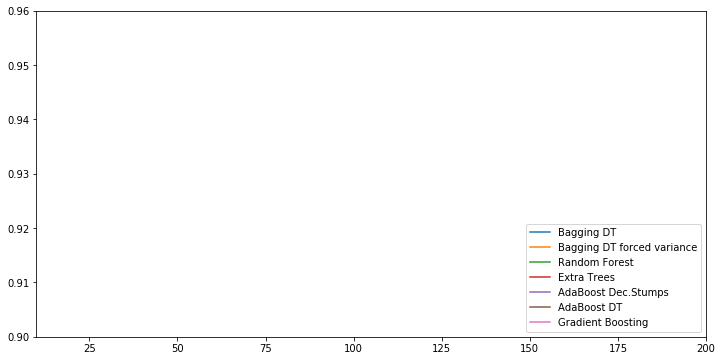

In [13]:
plt.figure(figsize=(12,6))
plt.plot([1,2,5,10,20,50,100,200],lb,label="Bagging DT")
plt.plot([1,2,5,10,20,50,100,200],lb2,label="Bagging DT forced variance")
plt.plot([1,2,5,10,20,50,100,200],lrf,label="Random Forest")
plt.plot([1,2,5,10,20,50,100,200],lext,label="Extra Trees")
plt.plot([1,2,5,10,20,50,100,200],lboo,label="AdaBoost Dec.Stumps")
plt.plot([1,2,5,10,20,50,100,200],lboodt,label="AdaBoost DT")
plt.plot([1,2,5,10,20,50,100,200],lgbboo,label="Gradient Boosting")
plt.legend(loc='lower right')
plt.xlim(10,200)
plt.ylim(0.90,0.96)
plt.show()

## Feature Selection with Forests of trees

In [14]:
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X, y)
print(clf.feature_importances_)  


[0.01644333 0.13711314 0.01498897 0.07818543 0.11172071 0.04966293
 0.04603915 0.02479212 0.06053607 0.00632967 0.04571201 0.05544841
 0.03083831 0.04171013 0.04379872 0.04062309 0.00454789 0.07071494
 0.07508605 0.04570892]


In [15]:
from sklearn.feature_selection import SelectFromModel

model = SelectFromModel(clf, prefit=True, threshold=0.05)
X_new = model.transform(X)
print(X_new.shape)

print(np.mean(cross_val_score(KNeighborsClassifier(), X=X, y=y, cv=cv, scoring='accuracy')))
print(np.mean(cross_val_score(KNeighborsClassifier(), X=X_new, y=y, cv=cv, scoring='accuracy')))

(8692, 7)
0.6121749980369774
0.6427361510259059


In [ ]:
thresholds=clf.feature_importances_

l=[]
lparval=[]
for threshold in thresholds:
    model = SelectFromModel(clf, prefit=True, threshold=threshold)
    X_new = model.transform(X)
    params = {'n_neighbors':list(range(1,30,2)), 'weights':('distance','uniform')}
    knc = KNeighborsClassifier()
    clf2 = GridSearchCV(knc, param_grid=params,cv=cv,n_jobs=-1)  # If cv is integer, by default is Stratifyed 
    clf2.fit(X, y)
    parval=clf2.best_params_
    clf3 = KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights'])
    acc = np.mean(cross_val_score(clf3, X=X_new, y=y, cv=cv, scoring='accuracy'))
    l.append(acc)
    lparval.append(parval)
    
plt.scatter(thresholds,l)
plt.show()

print('Best threshold: ',thresholds[np.argmax(l)])

In [ ]:
parval=lparval[np.argmax(l)]
model = SelectFromModel(clf, prefit=True, threshold=thresholds[np.argmax(l)])
X_new = model.transform(X)
print(X_new.shape)

print('Original: ', np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=1), X=X, y=y, cv=cv, scoring='accuracy')))
print('With FS: ', np.mean(cross_val_score(KNeighborsClassifier(n_neighbors=parval['n_neighbors'],weights=parval['weights']), X=X_new, y=y, cv=cv, scoring='accuracy')))